# <center>The goal of this script is to analyze a set of countries and their characteristics in order to help the growth of an agribusiness company that specializes in chicken<center>

<b> Importing the necessary libraries for the following analyses: <b>

In [1]:
import pandas as pd
import numpy as np

from functions import *

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.stats import kstest
import scipy.stats as stats

import matplotlib.pyplot as plt

# Task 1 - A sample of all available countries including 4 new variables

<b> Importing data: <b>

In [2]:
ogdata = pd.read_csv(r"C:\Users\Blagoj\OneDrive\Documents\Openclassrooms\Project 6\Public Health Study.csv")

### First variable - Difference in population between 2014 and 2019, expressed as a percentage

In [3]:
# Sorting the countries by year. Necessary for the next step
ogdata = ogdata.sort_values(by=['country', 'year'], ascending=True).reset_index(drop=True)

# Calculating the population change
ogdata['pop_percentage_change'] = ogdata.groupby('country')['population'].pct_change() * 100


### Second variable - Food availability in protein per capita

In [4]:
# Calculating the amount of protein per line
ogdata['protein'] = (ogdata['domestic_supply_quantity']*1000000) * ogdata['protein_percentage']

# Calculating food availability in proteins per capita
ogdata['protein_per_capita'] = ogdata['protein'] * 365 / (ogdata['population']*1000)

### Third variable - Food availability in calories per capita

In [5]:
ogdata['calories_per_capita'] = ogdata['food_supply_kcalcapitaday']*365

### Fourth variable - Proportion of animal proteins compared to the total amount of proteins available

In [6]:
# Calculating the full protein sum and animal protein sum by grouping by country and year
full_protein_sum = ogdata.groupby(['country', 'year'])['protein'].sum().reset_index()
animal_protein_sum = ogdata[ogdata['origin'] == 'animal'].groupby(['country', 'year'])['protein'].sum().reset_index()

# Calculating the proportion of animal protein vs total
protein_prop_animal = pd.merge(full_protein_sum, animal_protein_sum, on=['country', 'year'], suffixes=('_full', '_animal'))
protein_prop_animal['protein_prop_animal'] = protein_prop_animal['protein_animal'] / protein_prop_animal['protein_full']

# Merging the protein_prop_animal dataframe with ogdata based on country and year
ogdata = pd.merge(ogdata, protein_prop_animal[['country', 'year', 'protein_prop_animal']], on=['country', 'year'], how='left')

## Cleaning the data from unnecessary columns and rows

In [7]:
# Selecting the desired colums
ogdata = ogdata[['country', 'year', 'population', 'pop_percentage_change', 'protein_prop_animal', 'protein_per_capita', 'calories_per_capita']]
population_data = ogdata['population'].copy()
# Filtering the dataframe for the year 2019
ogdata = ogdata[ogdata['year'] == 2019]

In [8]:
# Grouping by country and calculating the protein_per_capita and calories_per_capita
ogdata = ogdata.groupby('country').agg({
    'pop_percentage_change': 'first',
    'protein_prop_animal': 'first',
    'protein_per_capita': 'sum',
    'calories_per_capita': 'sum'
}).reset_index()

ogdata.head()

,country,pop_percentage_change,protein_prop_animal,protein_per_capita,calories_per_capita
0,Afghanistan,13.997183,0.197115,9603.880646,828915.0
1,Albania,-0.517956,0.403927,23991.217689,1216910.0
2,Algeria,10.607851,0.192295,18185.474891,1273850.0
3,Angola,18.124118,0.220806,10032.130161,890965.0
4,Antigua and Barbuda,4.301075,0.651111,12035.337915,906295.0


# Task 2 - A dendrogram containing all the studied countries, split into five groups

### Performing a hierarchical clustering in order to plot the dendogram

Cluster 1: ['Afghanistan', 'Angola', 'Benin', 'Bolivia (Plurinational State of)', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Ecuador', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Jordan', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Oman', 'Pakistan', 'Papua New Guinea', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tajikistan', 'Timor-Leste', 'Togo', 'Uganda', 'United Republic of Tanzania', 'Vanuatu', 'Yemen', 'Zambia', 'Zimbabwe']
Cluster 2: ['Algeria', 'Azerbaijan', 'Bangladesh', 'Cabo Verde', 'Cambodia', 'China, mainland', 'Colombia', 'Costa Rica', 'Djibouti', 'Dominican Republic', 'Egypt', 'El Salvador', 'Eswatini', 'Guyana', 'Honduras', '

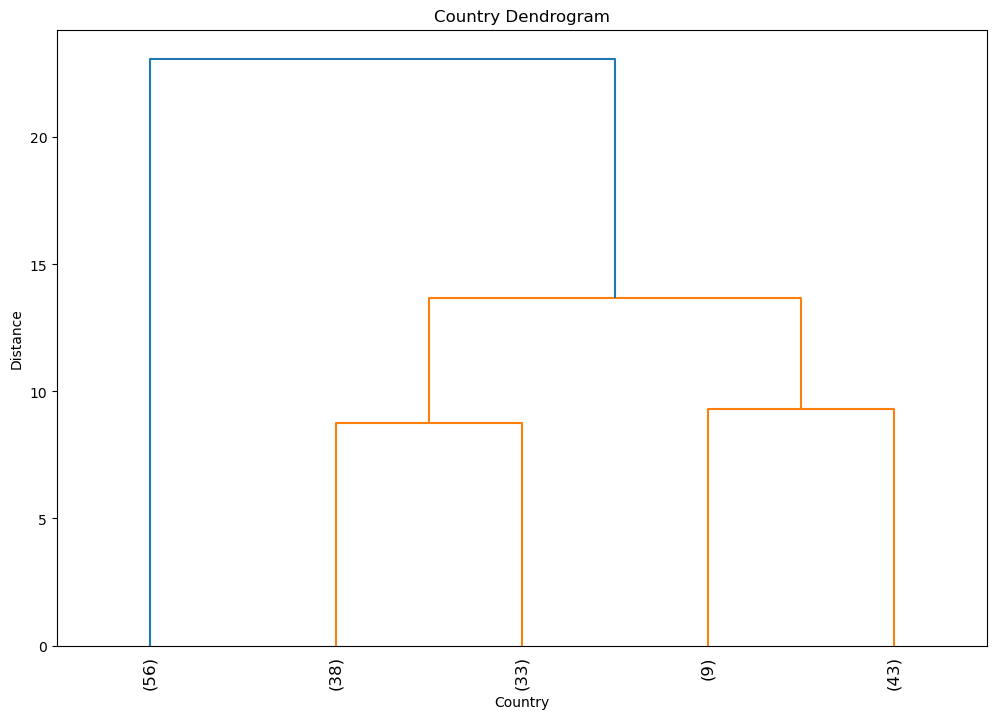

In [9]:
# Standardizing the data
stddata=ogdata
columns = ["pop_percentage_change", "protein_per_capita", "calories_per_capita", "protein_prop_animal"]
stddata[columns] = (stddata[columns] - stddata[columns].mean()) / stddata[columns].std()

# Linkage
Z = linkage(stddata[columns], method="ward", metric="euclidean")

max_d = 8
    
clusters = fcluster(Z, max_d, criterion='distance')
clust_amount = int(clusters.max())

# Clustering the countries (hierarchical)
stddata['cluster'] = clusters

# Printing the list of countries from each cluster
sorted_leaf_labels = []
for cluster in range(1, clusters.max() + 1):
    cluster_indices = stddata[stddata['cluster'] == cluster].index
    sorted_leaf_labels.extend(cluster_indices)
    print(f"Cluster {cluster}: {stddata[stddata['cluster'] == cluster]['country'].tolist()}")

# Plotting dendogram
plt.figure(figsize=(12, 8))
plt.title('Country Dendrogram')
plt.xlabel('Country')
plt.ylabel('Distance')
dendrogram(Z, truncate_mode="lastp", p=clust_amount, leaf_rotation=90, leaf_font_size=12, labels=stddata['country'].tolist())
plt.show()

country_clusters = pd.DataFrame({'Country': stddata['country'], 'Cluster': stddata['cluster']})
country_clusters.to_csv(r'C:\Users\Blagoj\OneDrive\Documents\Openclassrooms\Project 6\country_clusters.csv', index=False)

### Identifying outliers for each variable in each cluster

In [10]:
#Central tendencies for each cluster
summary = stddata.groupby('cluster')[columns].agg(['mean', 'median', 'std'])

#Identifying countries with values that are significantly different from the cluster means
for cluster in summary.index:
    print('Cluster {}:'.format(cluster))
    for col in columns:
        mean = summary.loc[cluster, (col, 'mean')]
        std = summary.loc[cluster, (col, 'std')]
        outliers = stddata[(stddata['cluster'] == cluster) & (stddata[col] > mean + 2*std)]
        print('  {}: {}'.format(col, ', '.join(outliers['country'].tolist())))


Cluster 1:
  pop_percentage_change: Maldives, Oman
  protein_per_capita: Mali, Niger
  calories_per_capita: Ghana
  protein_prop_animal: Maldives, Pakistan, Papua New Guinea
Cluster 2:
  pop_percentage_change: Egypt
  protein_per_capita: China, mainland
  calories_per_capita: Tunisia, Türkiye
  protein_prop_animal: 
Cluster 3:
  pop_percentage_change: 
  protein_per_capita: Belize
  calories_per_capita: 
  protein_prop_animal: Mongolia
Cluster 4:
  pop_percentage_change: Kiribati
  protein_per_capita: Saint Kitts and Nevis
  calories_per_capita: 
  protein_prop_animal: Saint Kitts and Nevis
Cluster 5:
  pop_percentage_change: Kazakhstan
  protein_per_capita: Belarus, Ireland, Lithuania
  calories_per_capita: United States of America
  protein_prop_animal: 


### Checking the average protein per capita in each cluster so we can see where there is a lack of protein

In [11]:
print(stddata[stddata['cluster'] == 1]['protein_per_capita'].mean())
print(stddata[stddata['cluster'] == 2]['protein_per_capita'].mean())
print(stddata[stddata['cluster'] == 3]['protein_per_capita'].mean())
print(stddata[stddata['cluster'] == 4]['protein_per_capita'].mean())
print(stddata[stddata['cluster'] == 5]['protein_per_capita'].mean())

-0.7794768754287306
-0.1877281630594345
-0.28756938982394065
1.6013400747340003
1.0665605677174734


In [12]:
temp=stddata[stddata['cluster'] == 1]
temp.head(15)

,country,pop_percentage_change,protein_prop_animal,protein_per_capita,calories_per_capita,cluster
0,Afghanistan,1.202113,-0.869592,-0.924726,-1.335567,1
3,Angola,1.880282,-0.722586,-0.884399,-0.963172,1
16,Benin,1.320498,-1.309761,-0.511491,-0.235907,1
17,Bolivia (Plurinational State of),0.139013,0.355388,-0.642869,-0.917170,1
19,Botswana,0.593251,0.207420,-0.766541,-0.687162,1
22,Burkina Faso,1.457636,-1.425466,-0.453566,-0.319148,1
23,Burundi,1.716840,-1.771758,-1.155885,-2.479037,1
26,Cameroon,1.215993,-1.414757,-0.518961,-0.240288,1
28,Central African Republic,-0.063600,-0.187709,-0.953673,-2.222742,1
29,Chad,1.647597,-0.454900,-0.455001,-1.333376,1


### Performing kmeans so we can obtain a CSV file containing the group centroids

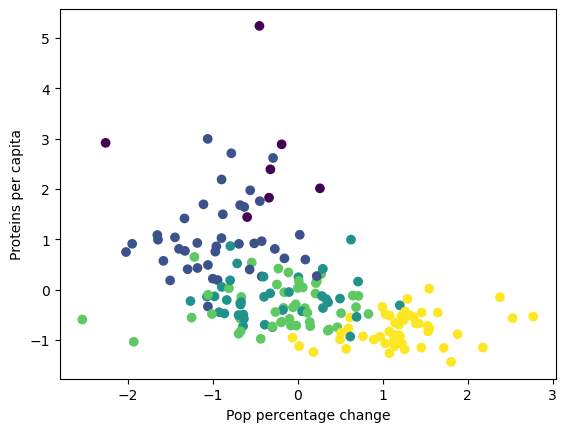

In [13]:
#Clustering the countries (k-means)
num_clusters=5
kmeans = KMeans(init='random', n_clusters=num_clusters, n_init=10)
kmeans.fit(stddata[columns])

clusters = kmeans.fit_predict(stddata[columns])
ogdata['cluster'] = clusters


plt.scatter(stddata['pop_percentage_change'], stddata['protein_per_capita'], c=stddata['cluster'])
plt.xlabel('Pop percentage change')
plt.ylabel('Proteins per capita')
plt.show()

In [14]:
# Iterating over the unique cluster labels
for cluster_label in stddata['cluster'].unique():
# Filtering the dataframe for the countries in the current cluster
    cluster_countries = stddata.loc[stddata['cluster'] == cluster_label, 'country']
    
# Creating a string with the cluster label and the list of countries
    countries_string = ', '.join(cluster_countries)
    
# Printing the cluster label and the list of countries
    print(f"Cluster {cluster_label}: {countries_string}")

Cluster 4: Afghanistan, Angola, Benin, Botswana, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Congo, Côte d'Ivoire, Democratic Republic of the Congo, Ethiopia, Gabon, Gambia, Guatemala, Guinea, Guinea-Bissau, Haiti, Iraq, Jordan, Kenya, Liberia, Madagascar, Malawi, Maldives, Mali, Mauritania, Mozambique, Namibia, Niger, Nigeria, Oman, Rwanda, Sao Tome and Principe, Senegal, Sierra Leone, Solomon Islands, Sudan, Tajikistan, Timor-Leste, Togo, Uganda, United Republic of Tanzania, Vanuatu, Yemen, Zambia, Zimbabwe
Cluster 1: Albania, Argentina, Australia, Austria, Belarus, Belgium, Bosnia and Herzegovina, Brazil, Bulgaria, Canada, China, Taiwan Province of, China, mainland, Croatia, Cuba, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Italy, Kazakhstan, Latvia, Netherlands, Poland, Portugal, Romania, Russian Federation, Serbia, Slovenia, Spain, Sweden, Tunisia, Türkiye, Ukraine, United Kingdom of Great Britain and Northern Ireland

C:\Users\Blagoj\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


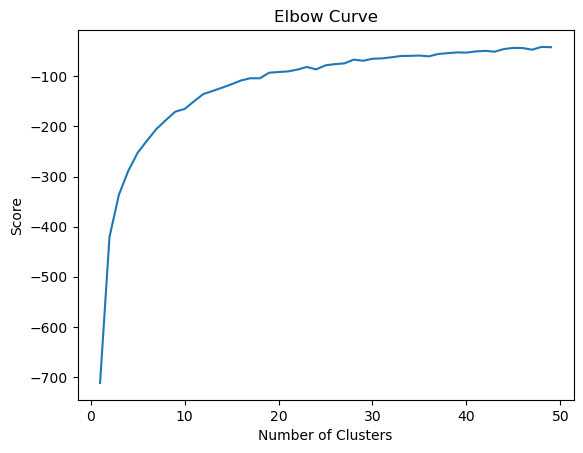

In [15]:
# Testing with number of clusters
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(ogdata[columns]).score(ogdata[columns]) for i in range(len(kmeans_tests))]

# Plotting the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

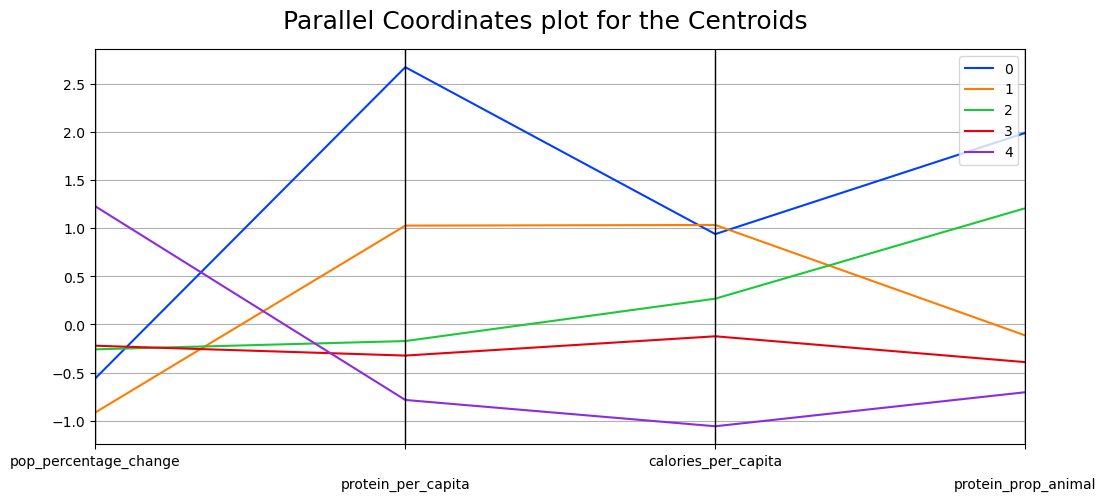

In [16]:
# Creating a data frame containing the centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=ogdata[columns].columns)
centroids['cluster'] = centroids.index

centroids.to_csv(r'C:\Users\Blagoj\OneDrive\Documents\Openclassrooms\Project 6\group_centroids.csv', index=False)

display_parallel_coordinates_centroids(centroids, 10)

# Task 3 - A short list (5-10) of potential countries

### Performing PCA

In [17]:
num_components=4
pca=PCA(n_components=num_components)
pca.fit(temp[columns])
data = pca.fit_transform(temp[columns])
data

array([[-2.27968195e-01, -2.66842813e-01,  2.53545810e-01,
         4.23476489e-02],
       [-2.75704067e-01,  4.34639055e-01,  5.94023732e-01,
         1.49805710e-01],
       [-8.63921064e-01,  6.22654407e-01, -3.72634860e-01,
         4.81717275e-02],
       [ 1.08629550e+00, -1.70456844e-01, -8.04583473e-01,
        -1.28064868e-01],
       [ 8.30355766e-01,  1.81657309e-01, -5.54708151e-01,
         8.28800047e-02],
       [-9.95660784e-01,  6.25863597e-01, -2.34303698e-01,
        -2.91426976e-02],
       [-1.02314161e+00, -1.11201413e+00,  1.28831508e+00,
        -1.07466616e-01],
       [-9.43567168e-01,  5.33231086e-01, -4.60155735e-01,
         5.26952724e-02],
       [ 8.09321317e-01, -1.47077009e+00, -2.17452381e-01,
        -2.85771555e-01],
       [ 4.84114477e-02,  2.19155491e-01,  5.52626179e-01,
        -3.92442827e-01],
       [ 5.94880494e-01, -2.46178107e-01,  5.69902809e-02,
         9.17993539e-02],
       [ 1.38367458e+00, -1.12261357e-01,  4.57589098e-01,
      

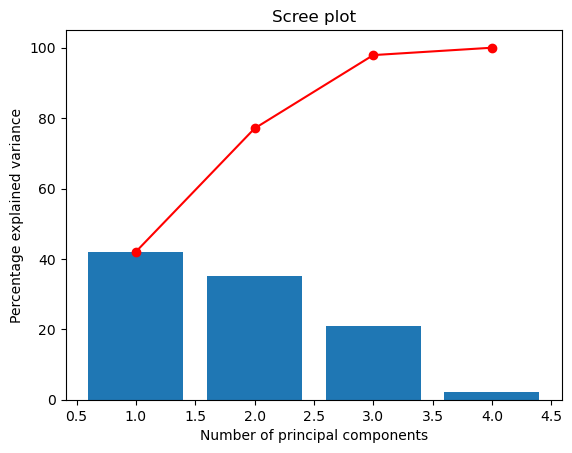

In [18]:
display_scree_plot(pca)

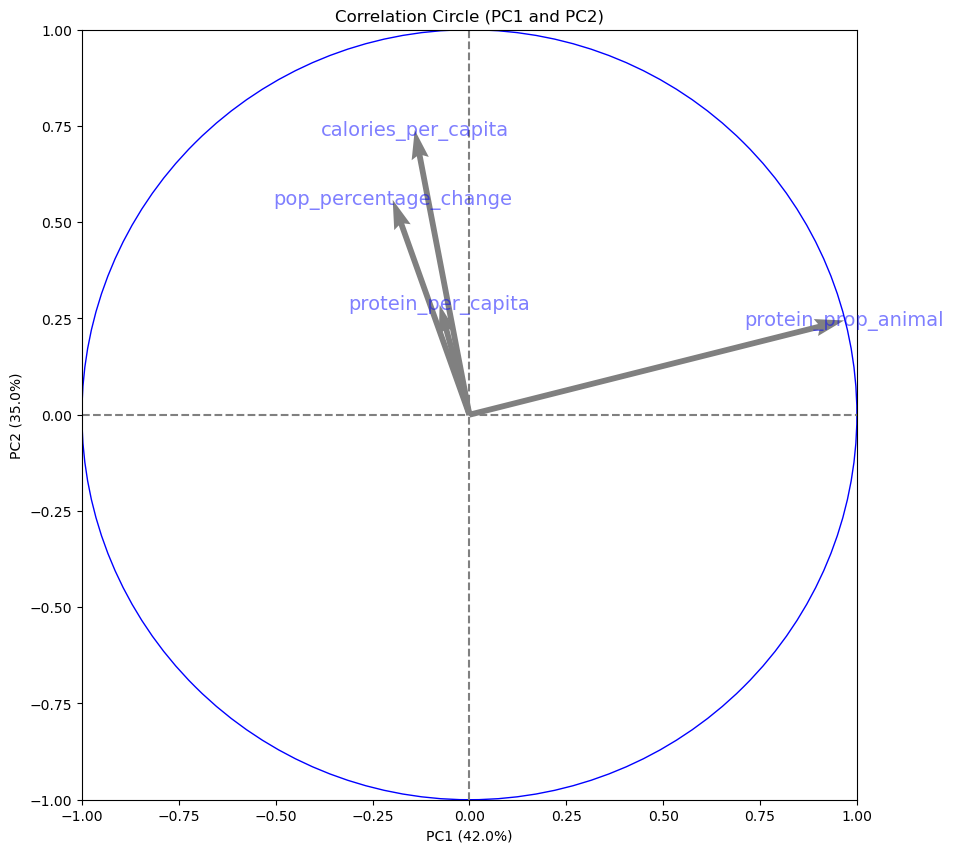

In [19]:
# Generating a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,1)], labels = np.array(columns),)

In [20]:
#pca_sums=np.sum(data, axis=1)
pca_sums = np.sum(data[:, :2], axis=1)
pca_sums

array([-0.49481101,  0.15893499, -0.24126666,  0.91583866,  1.01201307,
       -0.36979719, -2.13515574, -0.41033608, -0.66144878,  0.26756694,
        0.34870239,  1.27141323,  0.20843072, -1.85086804, -1.56597599,
        1.25463406, -1.14622272,  1.72162879,  0.45127507,  0.13027198,
        0.02602251, -0.32451411, -1.00919045, -0.99224535, -0.46662752,
        0.11297372, -0.31553263, -0.26994643, -0.45919567, -1.13209365,
       -0.4241545 ,  3.45770766,  0.11492147,  1.8066774 , -0.71530351,
        0.46226359, -0.15824947, -0.88573878,  3.34848356,  2.25274476,
        1.89862743, -1.09101316,  0.75077312, -0.28145299, -0.71900682,
        0.16593877, -0.08019505,  0.24548427, -0.79627015, -0.77822416,
       -0.36380123, -0.43978941,  0.80772274, -0.88162703, -0.3784687 ,
       -1.35252793])

In [21]:
temp_copy = temp.copy()
temp_copy.loc[:, 'pca_sums'] = pca_sums
temp_copy = temp_copy.sort_values(by='pca_sums', ascending=False)
cluster1_outliers=['Maldives','Oman', 'Mali', 'Niger', 'Ghana', 'Pakistan', 'Papua New Guinea']
temp_copy = temp_copy[~temp_copy['country'].isin(cluster1_outliers)]
temp_copy.head(10)

#the bigger the pca sum value - the better explanation per country

,country,pop_percentage_change,protein_prop_animal,protein_per_capita,calories_per_capita,cluster,pca_sums
104,Mauritania,1.389268,0.278009,-0.671239,-0.014661,1,1.806677
60,Gabon,1.422726,0.465066,-0.671223,-0.555728,1,1.721629
37,Congo,1.136040,0.739064,-1.123144,-1.532717,1,1.271413
50,Ecuador,0.366846,0.484773,-0.792221,-0.698115,1,1.254634
19,Botswana,0.593251,0.207420,-0.766541,-0.687162,1,1.012013
17,Bolivia (Plurinational State of),0.139013,0.355388,-0.642869,-0.917170,1,0.915839
173,Vanuatu,1.142820,-0.185234,-0.659141,-0.601730,1,0.807723
140,Sao Tome and Principe,0.494962,0.239955,-0.988579,-1.052985,1,0.750773
112,Namibia,0.506949,-0.104154,-0.858400,-0.890884,1,0.462264
61,Gambia,1.532530,-0.427533,-0.828943,-0.882121,1,0.451275


In [22]:
chosen=temp_copy.head(6)
chosen.head(6)

,country,pop_percentage_change,protein_prop_animal,protein_per_capita,calories_per_capita,cluster,pca_sums
104,Mauritania,1.389268,0.278009,-0.671239,-0.014661,1,1.806677
60,Gabon,1.422726,0.465066,-0.671223,-0.555728,1,1.721629
37,Congo,1.136040,0.739064,-1.123144,-1.532717,1,1.271413
50,Ecuador,0.366846,0.484773,-0.792221,-0.698115,1,1.254634
19,Botswana,0.593251,0.207420,-0.766541,-0.687162,1,1.012013
17,Bolivia (Plurinational State of),0.139013,0.355388,-0.642869,-0.917170,1,0.915839


# Task 4 -  Statistical tests

### An Adequacy Test to find a normal distribution variable

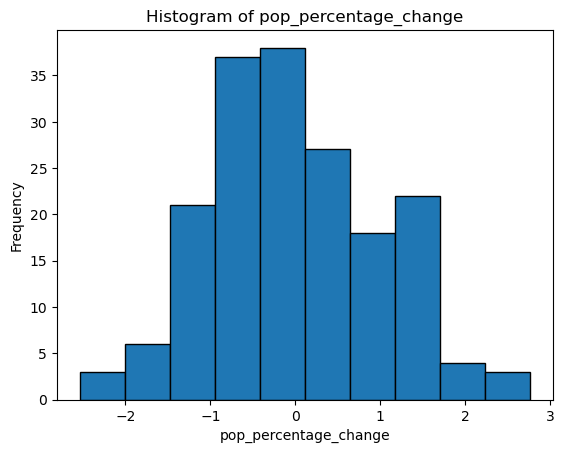

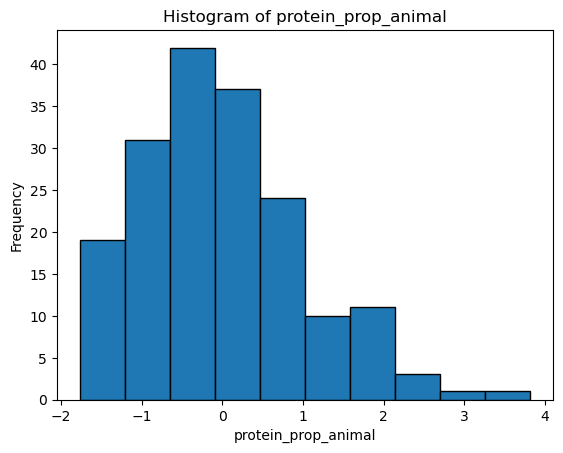

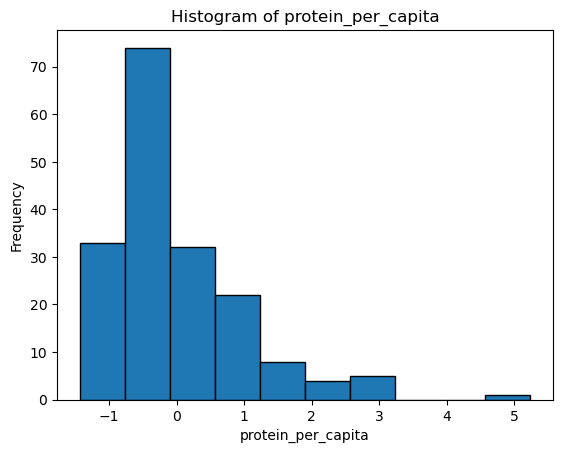

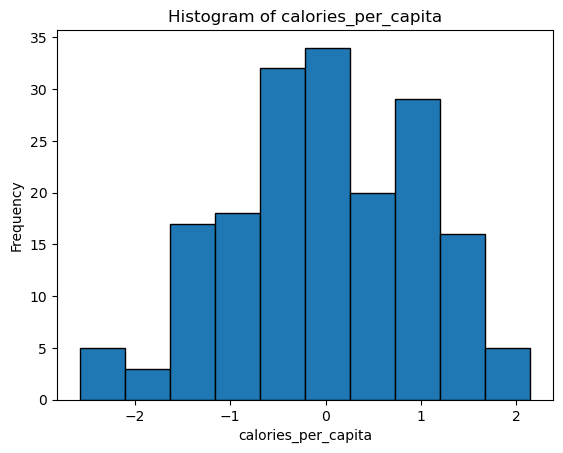

In [23]:
# (Visual Method) Creating histograms:
variables = ['pop_percentage_change', 'protein_prop_animal', 'protein_per_capita', 'calories_per_capita']

for variable in variables:
    plt.hist(ogdata[variable], bins=10, edgecolor='black', density=False)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(variable))
    plt.show()

In [24]:
#Based on the histograms, it seems that the first variable is most likely to have a normal distribution so we are going
#to do an additional test to confirm that:
variable = 'pop_percentage_change'
data = ogdata[variable]
result = kstest(data, 'norm')
print('Variable:', variable)
print('KS Test Statistic:', result.statistic)
print('KS Test p-value:', result.pvalue)
print('Is normally distributed:', result.pvalue > 0.05)
print('-' * 20)

Variable: pop_percentage_change
KS Test Statistic: 0.060033241536194715
KS Test p-value: 0.5194339298571743
Is normally distributed: True
--------------------


### A comparison test of two populations

In [25]:
# Extract data for the two clusters you want to compare
cluster1_data = (stddata[stddata['cluster'] == 1]['pop_percentage_change'])
cluster2_data = (stddata[stddata['cluster'] == 2]['pop_percentage_change'])

# Performing the KS test
result = stats.ks_2samp(cluster1_data, cluster2_data)

# Interpreting the KS test results
print('KS Test Statistic:', result.statistic)
print('KS Test p-value:', result.pvalue)
print('Are the populations different:', result.pvalue < 0.05)

KS Test Statistic: 0.4638888888888889
KS Test p-value: 0.0003187193290306895
Are the populations different: True
